## Learning Gradient of a 2-D Convex Function

In [14]:
## Learning gradient of a convex function

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt 
from jac_utils import check_jac_psd
from models import mGradNet_M, mGradNet_C
import numpy as np
import os 

seed = 42
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU available. Using : " + torch.cuda.get_device_name(0))
    torch.cuda.manual_seed(seed)
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU available. Using : NVIDIA GeForce RTX 2080 Ti


In [15]:
# The convex function 
def convex_function(x, y):
    return x**4 + (x**2)/2 + (x*y)/2 + 3*(y**2)/2 - (y**3)/3

# The gradient of the convex function
def field(z):
    x = z[:,0]
    y = z[:,1]
    return torch.stack([4*x**3 + 0.5*y + x, 3*y - y**2 + 0.5*x ]).T

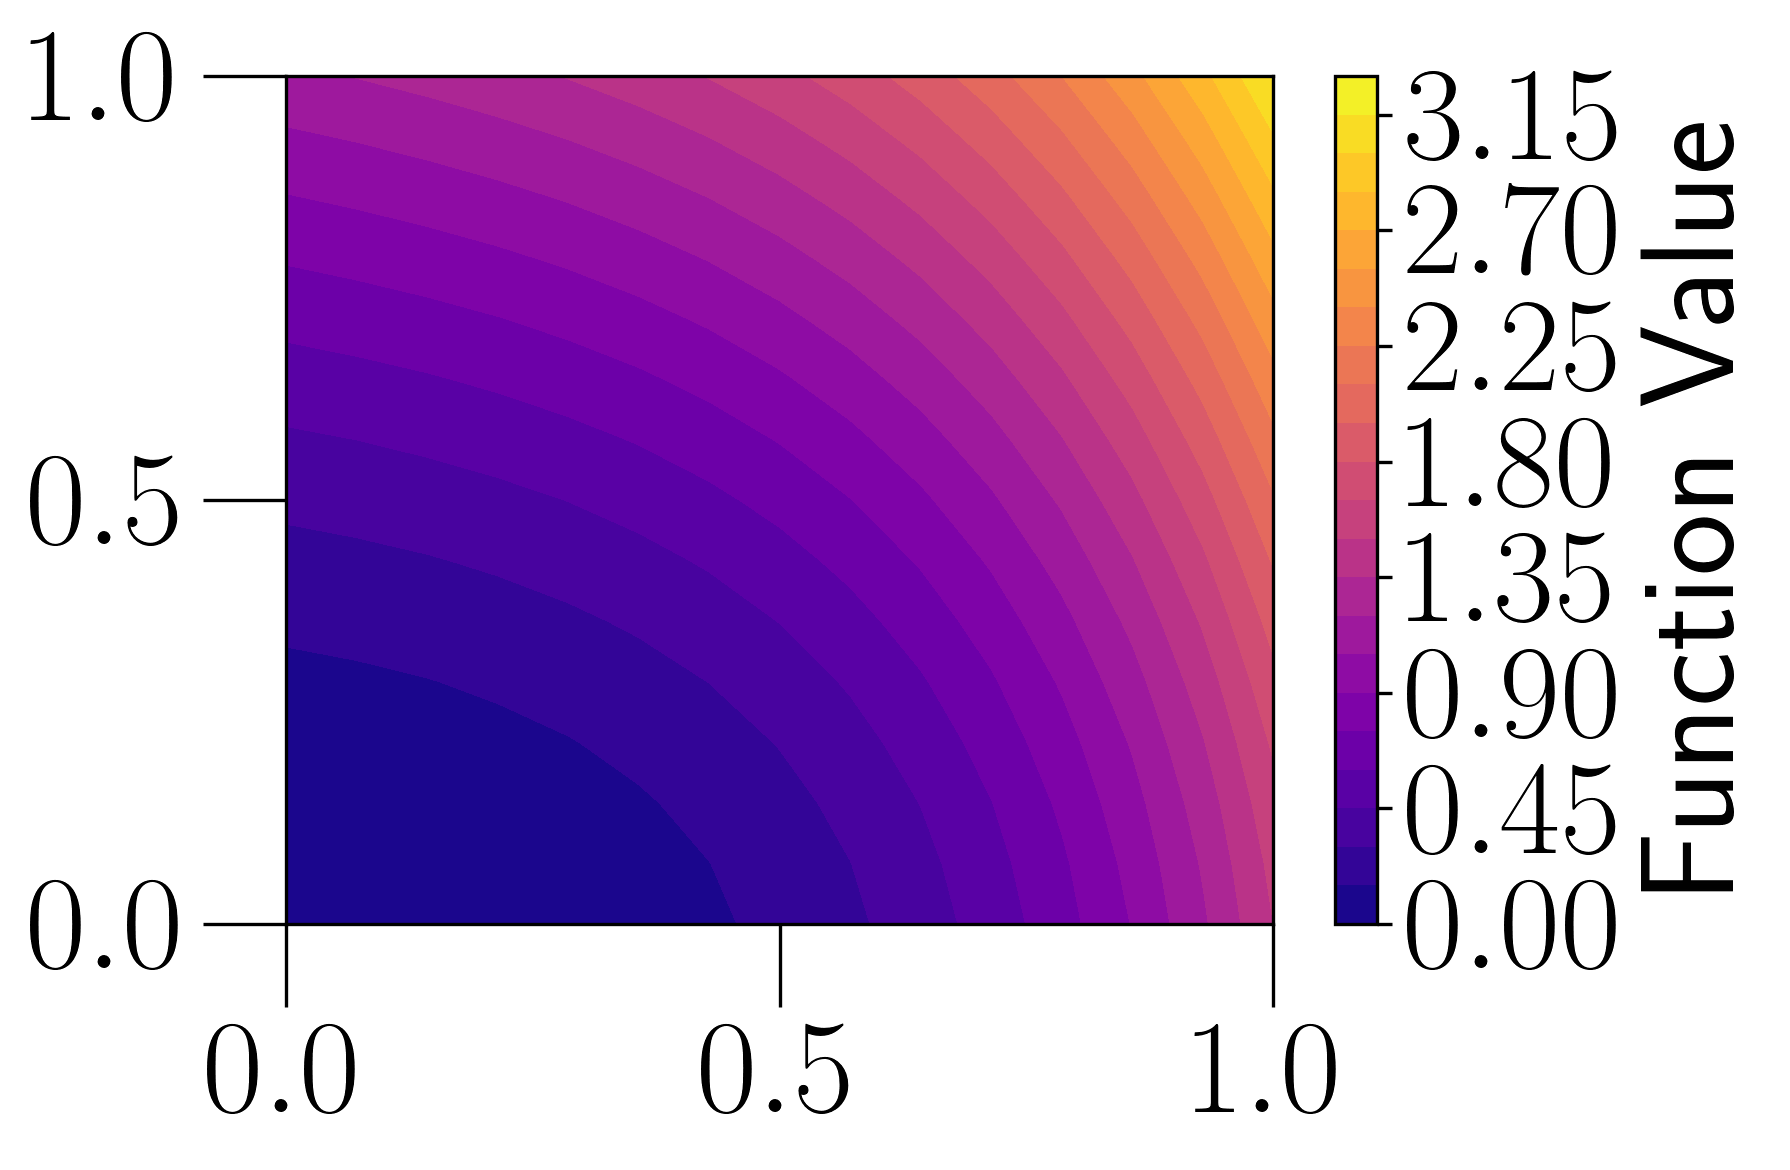

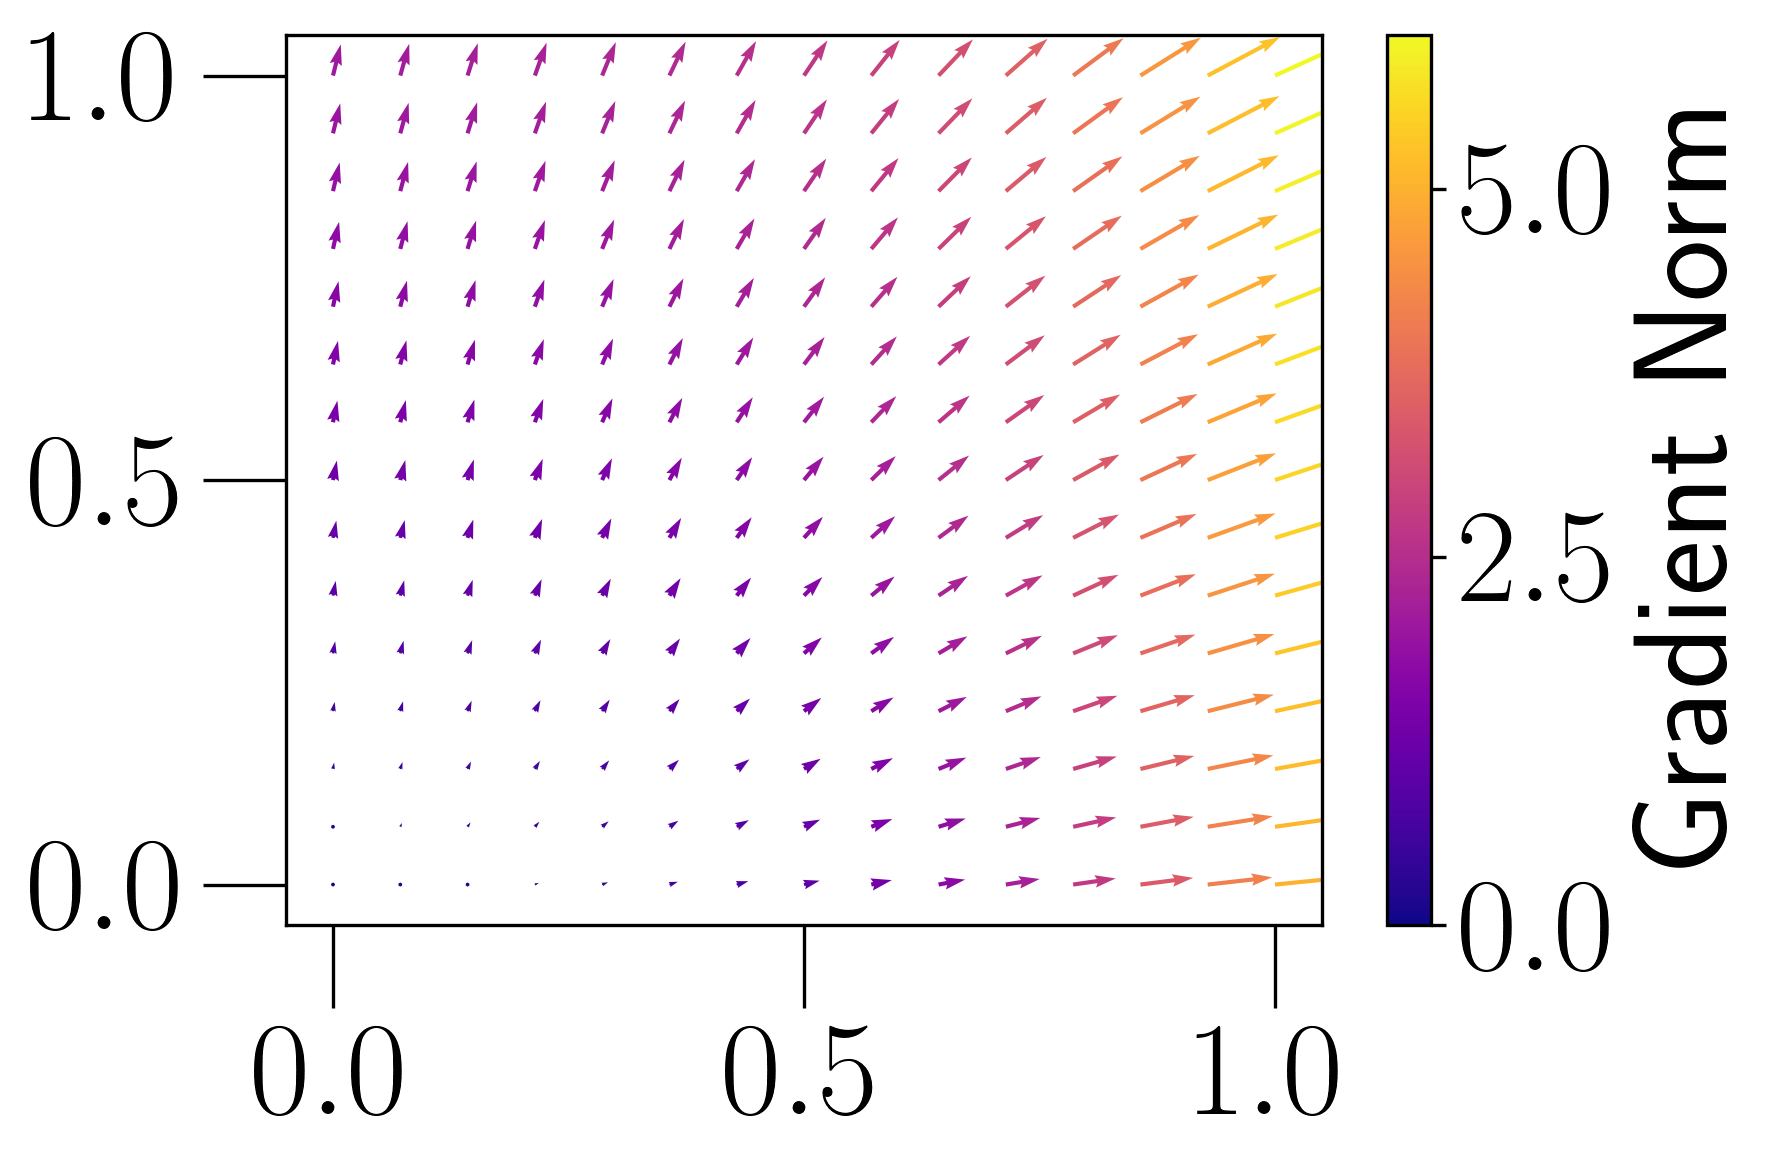

In [16]:
x = torch.linspace(0, 1, 15)
y = torch.linspace(0, 1, 15)

X, Y = torch.meshgrid(x, y)
space = torch.cat([torch.reshape(X,(-1,1)),torch.reshape(Y,(-1,1))],1)
grad = field(space)

plt.rcParams['text.usetex'] = True
label_size = 32
title_size= 48
cmap = 'plasma'
levels = 30

# Create contour plot
plt.figure(figsize=(6, 4), dpi=300)
plt.contourf(x, y, convex_function(space[:,0], space[:,1]).view(x.numel(),x.numel()).T, levels=levels, cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar()
cbar.set_label('Function Value', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

# Create quiver plot
plt.figure(figsize=(6, 4), dpi=300)
p = plt.quiver(space[:,0], space[:,1], grad[:,0], grad[:,1], grad.norm(dim=-1), cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar(p)
cbar.set_label('Gradient Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

In [17]:
def train_model(model, data_loader, val_pts, field, model_name):

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    best_val_loss = float('Inf')

    train_loss_hist = []
    val_loss_hist = []

    for epoch in range(1,201):
        avg_train_loss = 0
        for i, (x, y) in enumerate(data_loader):
            out = model(x.to(device))
            loss = F.mse_loss(out, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()
        
        avg_train_loss = avg_train_loss / len(data_loader)
        
        with torch.no_grad():
            val_loss = F.mse_loss(model(val_pts.to(device)), field(val_pts).to(device)).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_name+'.pt')
        
        train_loss_hist.append(avg_train_loss)
        val_loss_hist.append(val_loss)
        if epoch % 10 == 0:
            print("Epoch: ", epoch, "Train Loss: ", avg_train_loss, "Val Loss: ", val_loss)
    
    model.load_state_dict(torch.load(model_name+'.pt'))
    return model

## Train mGradNets

In [18]:
train_pts = torch.rand(size=(100000, 2))
val_pts = torch.rand(size=(10000, 2))
data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=1000, shuffle=True, num_workers=8)

mgn_c = mGradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
mgn_m = mGradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired

print("mGN-C parameters", sum(p.size().numel() for p in mgn_c.parameters() if p.requires_grad))
print("mGN-M parameters", sum(p.size().numel() for p in mgn_m.parameters() if p.requires_grad))

mgn_c = train_model(mgn_c, data_loader=data_loader, val_pts=val_pts, field=field, model_name='mgn_c')
mgn_m = train_model(mgn_m, data_loader=data_loader, val_pts=val_pts, field=field, model_name='mgn_m')

mGN-C parameters 100
mGN-M parameters 94


Epoch:  10 Train Loss:  0.002620835709385574 Val Loss:  0.0024093089159578085
Epoch:  20 Train Loss:  0.0007788753981003537 Val Loss:  0.0007210625917650759
Epoch:  30 Train Loss:  0.00024087550060357898 Val Loss:  0.00022282566351350397
Epoch:  40 Train Loss:  6.221522471605567e-05 Val Loss:  5.710189725505188e-05
Epoch:  50 Train Loss:  2.9286579047038685e-05 Val Loss:  2.7320340450387448e-05
Epoch:  60 Train Loss:  2.7998653113172623e-05 Val Loss:  3.0335655537783168e-05
Epoch:  70 Train Loss:  2.453145967592718e-05 Val Loss:  2.513353683752939e-05
Epoch:  80 Train Loss:  2.292553557708743e-05 Val Loss:  2.1263960661599413e-05
Epoch:  90 Train Loss:  2.423010662823799e-05 Val Loss:  1.58110233314801e-05
Epoch:  100 Train Loss:  1.4018411075085169e-05 Val Loss:  1.837255695136264e-05
Epoch:  110 Train Loss:  1.2520613809101633e-05 Val Loss:  1.65587571245851e-05
Epoch:  120 Train Loss:  1.1808022591139889e-05 Val Loss:  1.1160248504893389e-05
Epoch:  130 Train Loss:  1.66393482777493

## Plot Errors

In [19]:
xi = torch.linspace(0, 1, 100)
yi = torch.linspace(0, 1, 100)

Xi, Yi = torch.meshgrid(xi, yi)
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = field(space)


def get_norm_err(model):
    with torch.no_grad():
        model = model.cpu()
        out = model(space)
    return (targ - out).norm(dim=1).reshape(Xi.shape).T

check_jac_psd(mgn_c.to(device), in_dim=2, device=device, domain=[0,1])
check_jac_psd(mgn_m.to(device), in_dim=2, device=device, domain=[0,1])

jacobian PSD Test Passed
jacobian PSD Test Passed


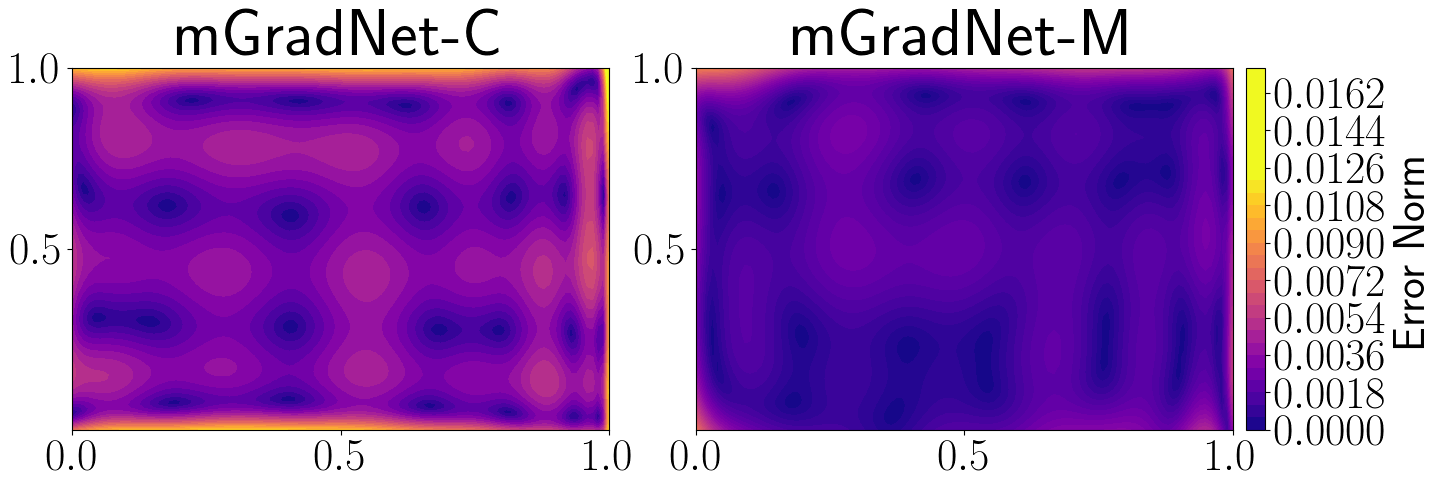

In [20]:
mgnc_err = get_norm_err(mgn_c)
mgnm_err = get_norm_err(mgn_m)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt1 = ax[0].contourf(xi, yi, mgnc_err, levels=levels, cmap=cmap, vmin=0, vmax=cmax)
plt2 = ax[1].contourf(xi, yi, mgnm_err, levels=levels, cmap=cmap, vmin=0, vmax=cmax)

ax[0].set_title('mGradNet-C',fontsize=title_size)
ax[1].set_title('mGradNet-M',fontsize=title_size)
ax[0].set_xticks([0, 0.5, 1.0])
ax[1].set_xticks([0, 0.5, 1.0])
ax[0].set_yticks([0.5, 1.0])
ax[1].set_yticks([0.5, 1.0])

ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)


plt.tight_layout()
if mgnc_err.amax() > mgnm_err.max():
    cbar = plt.colorbar(plt1, ax=ax, pad= 0.01)
else:
    cbar = plt.colorbar(plt2, ax=ax, pad= 0.01)
cbar.set_label('Error Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 